In [1]:
# force torch to use CPU
import torch
# torch.cuda.empty_cache()
torch.cuda.is_available = lambda : False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sops_anomaly.datasets import NabDataset, SupervisedDataset
from sops_anomaly.detectors import AutoEncoder, VariationalAutoEncoder, LSTM_AD
from sops_anomaly.evaluation import Result

In [3]:
def max_metric(scores, targets, threshold_range, metric):
    best_metric = -1
    best_result = None
    best_threshold = 0
    for threshold in threshold_range:
        labels = (scores > threshold).astype(np.int32)
        result = Result(labels, targets)
        current_metric = getattr(result, metric, -1)
        if current_metric > best_metric:
            best_metric = current_metric
            best_result = result
            best_threshold = threshold
    return best_result, best_threshold, best_metric

def best_result(predictions, targets, max_error=None):
    """Try various threshold levels to get best scores."""
    
    if max_error is None:
        threshold_range = np.linspace(
            np.min(predictions), 
            min(3*np.mean(predictions), np.max(predictions)), 
            100,
        )
    else:
        threshold_range = np.linspace(0, max_error, 100)
        
    if np.any(targets):
        # If dataset contains anomalies maximize f1 score.
        result, threshold, _ = max_metric(predictions, targets, threshold_range, 'f1')
    else:
        # If dataset contains no anomalies maximize accuracy.
        result, threshold, _ = max_metric(predictions, targets, threshold_range, 'accuracy')
    return result, threshold

No handles with labels found to put in legend.


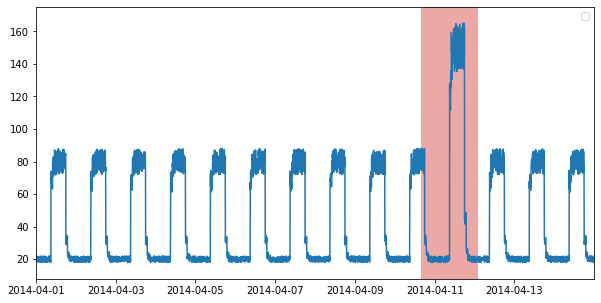

In [4]:
nab = NabDataset()
nab.plot()

In [5]:
# model = AutoEncoder(window_size=100, layers=(64, 32, 16), latent_size=10)
model = LSTM_AD(window_size=120)
_, y = nab.data
x = nab.get_train_samples(normalize=True)
x_train = x[y != 1]
model.train(x_train, epochs=50, learning_rate=1e-4, verbose=True)

Epoch 0 loss: 0.7766302874569756
Epoch 1 loss: 0.7765129627445204
Epoch 2 loss: 0.7763960237540023
Epoch 3 loss: 0.7762794583517556
Epoch 4 loss: 0.7761632505228834
Epoch 5 loss: 0.7760473823581892
Epoch 6 loss: 0.7759318365570859
Epoch 7 loss: 0.7758165959108821
Epoch 8 loss: 0.775701642340037
Epoch 9 loss: 0.7755869561814637
Epoch 10 loss: 0.7754725159554108
Epoch 11 loss: 0.7753582984858177
Epoch 12 loss: 0.7752442791643869
Epoch 13 loss: 0.7751304321995268
Epoch 14 loss: 0.7750167308030369
Epoch 15 loss: 0.7749031473268023
Epoch 16 loss: 0.7747896533551565
Epoch 17 loss: 0.7746762197494435
Epoch 18 loss: 0.7745628166480606
Epoch 19 loss: 0.7744494134343081
Epoch 20 loss: 0.7743359786866519
Epoch 21 loss: 0.7742224801225147
Epoch 22 loss: 0.7741088845424817
Epoch 23 loss: 0.7739951577796067
Epoch 24 loss: 0.7738812646577397
Epoch 25 loss: 0.7737671689621017
Epoch 26 loss: 0.773652833424219
Epoch 27 loss: 0.7735382197218591
Epoch 28 loss: 0.7734232884929032
Epoch 29 loss: 0.773307999

Result(accuracy=0.94,
	precision=0.91,
	recall=0.47,
	f1=0.62,
	roc_auc=0.73,
	y_pred%=0.05233134920634921,
	y_label%=0.09995039682539683,
)


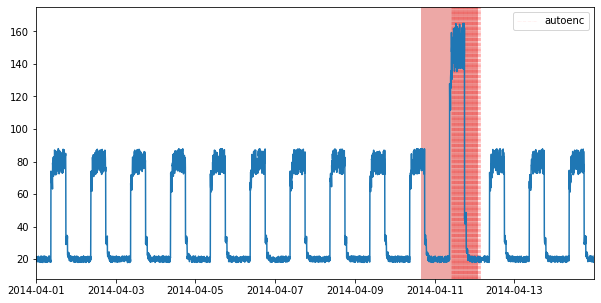

In [6]:
scores = model.predict(x)
result, threshold = best_result(scores, y)
anomalies = (scores > threshold).astype(np.int32)
print(result)
nab.plot(anomalies={'autoenc': anomalies})
plt.show()

In [36]:
NabDataset.datasets()

defaultdict(list,
            {'artificialNoAnomaly': ['art_daily_no_noise.csv',
              'art_daily_perfect_square_wave.csv',
              'art_daily_small_noise.csv',
              'art_flatline.csv',
              'art_noisy.csv'],
             'artificialWithAnomaly': ['art_daily_flatmiddle.csv',
              'art_daily_jumpsdown.csv',
              'art_daily_jumpsup.csv',
              'art_daily_nojump.csv',
              'art_increase_spike_density.csv',
              'art_load_balancer_spikes.csv'],
             'realAWSCloudwatch': ['ec2_cpu_utilization_24ae8d.csv',
              'ec2_cpu_utilization_53ea38.csv',
              'ec2_cpu_utilization_5f5533.csv',
              'ec2_cpu_utilization_77c1ca.csv',
              'ec2_cpu_utilization_825cc2.csv',
              'ec2_cpu_utilization_ac20cd.csv',
              'ec2_cpu_utilization_c6585a.csv',
              'ec2_cpu_utilization_fe7f93.csv',
              'ec2_disk_write_bytes_1ef3de.csv',
              'ec2_disk_w

Result(accuracy=0.84,
	precision=0.26,
	recall=0.34,
	f1=0.3,
	roc_auc=0.62,
	y_pred%=0.13020833333333334,
	y_label%=0.10044642857142858,
)


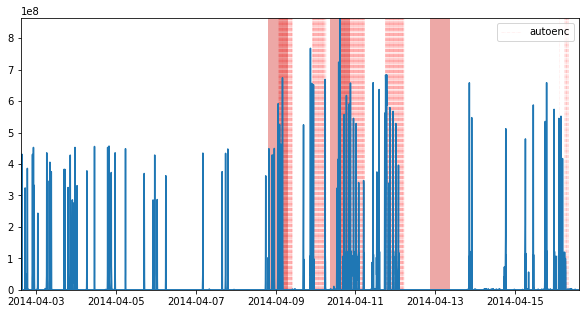

In [27]:
dataset = NabDataset(dataset="realAWSCloudwatch", file="ec2_disk_write_bytes_c0d644.csv")
# dataset.plot()
# plt.show()

model = AutoEncoder(window_size=100, layers=(64, 32, 16), latent_size=10)
x, y = dataset.data
x_train = x[y != 1]
model.train(x_train, epochs=40)

scores = model.predict(x)
result, threshold = best_result(scores, y)
anomalies = (scores > threshold).astype(np.int32)

dataset.plot(anomalies={'autoenc': anomalies})
print(result)
plt.show()

Result(accuracy=0.87,
	precision=0.36,
	recall=0.4,
	f1=0.38,
	roc_auc=0.66,
	y_pred%=0.11080367249402591,
	y_label%=0.09986165262231166,
)


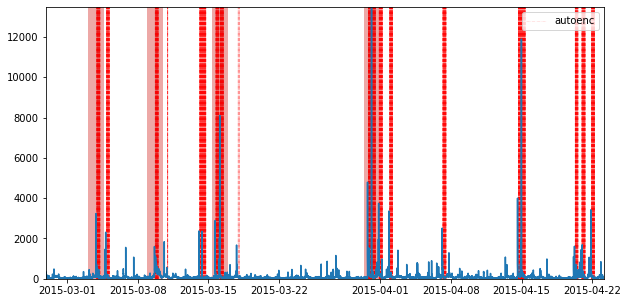

In [12]:
dataset.plot(anomalies={'autoenc': anomalies}, anomaly_style_kwargs={'lw': 0.5, 'ls': '-.', 'alpha': 0.2})
print(result)
plt.show()

In [43]:
def save_results(index, results, anomalies, root_folder):
    scores = [
        [r.accuracy, r.f1, r.precision, r.recall, r.roc_auc]
        for r
        in results
    ]
    columns = ['accuracy', 'f1_score', 'precision', 'recall', 'roc_auc']
    
    if not root_folder.exists():
        root_folder.mkdir(parents=True)
    
    pd.DataFrame(data=scores, index=index, columns=columns).to_csv(root_folder / "scores.csv")
    for idx, report in zip(index, anomalies):
        dataset, file = idx.split('/')
        folder = root_folder / dataset
        if not folder.exists():
            folder.mkdir(parents=True)
        report.to_csv(folder / file)
        
    # Save results files in proper hierarchy
#     pd.DataFrame(data=np.array(anomalies).T, columns=index).to_csv(anomalies_file_path)

In [54]:
RESULTS_ROOT = pathlib.Path('../results/nab_results')

# datasets = NabDataset.datasets()
datasets = {'artificialWithAnomaly': ['art_daily_flatmiddle.csv',
              'art_daily_jumpsup.csv',]}
def test_for_all(model_factory, folder_name):
    index = []
    all_results = []
    all_anomalies = []
#     for dataset, files in NabDataset.datasets():
    for dataset_name, files in datasets.items():
        for file in files:
            print(f"Testing on {dataset_name}/{file} ...")
            dataset = NabDataset(dataset=dataset_name, file=file)
            x, y = dataset.data
            x_train = x[y != 1]

            model = model_factory()
            model.train(x_train, epochs=50)
            
            scores = model.predict(x)
            result, threshold = best_result(scores, y)
            print(result)
            
            anomalies = (scores > threshold).astype(np.int32)
        
            index.append(f"{dataset_name}/{file}")
            all_results.append(result)
            
            anomaly_report = x.copy()
            anomaly_report['anomaly_score'] = anomalies
            anomaly_report['label'] = np.array(y).astype(np.int32)
            all_anomalies.append(anomaly_report)
            
    save_results(index, all_results, all_anomalies, root_folder=RESULTS_ROOT / folder_name)

In [55]:
test_for_all(
    lambda: AutoEncoder(window_size=100, layers=(64, 32, 16), latent_size=10), 
    folder_name="autoencoder",
)

Testing on artificialWithAnomaly/art_daily_flatmiddle.csv ...


KeyboardInterrupt: 

In [56]:
test_for_all(
    lambda: LSTM_AD(window_size=100, hidden_size=200), 
    folder_name="lstm_ad",
)

Testing on artificialWithAnomaly/art_daily_flatmiddle.csv ...


TypeError: __init__() got an unexpected keyword argument 'window_size'